In [8]:
import sys
sys.path.append("YOUR/PATH/TO/ROOT/DIRECTORY")

import time
import os
from string import ascii_letters
import pandas as pd
import seaborn as sns
import pickle
import warnings

from src.pipeline_mimic import *
from src.learn_kernel import *

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [9]:
import pylab

params = {
    "legend.fontsize": "xx-large",
    "axes.labelsize": "xx-large",
    "xtick.labelsize": "xx-large",
    "ytick.labelsize": "xx-large",
    "axes.titlesize": "xx-large",
    "figure.titlesize": "xx-large",
    "axes.linewidth": 0.8,
    "lines.linewidth": 3,
    "lines.markersize": 10.0,
}

pylab.rcParams.update(params)

<IPython.core.display.Javascript object>

# Data Loading

In [11]:
path = "YOUR/PATH/TO/DATA"
actions = pickle.load(open(path + "actions_discretized_vaso5_fluid4_1hr.p", "rb"))
states = pickle.load(open(path + "states_1hr.p", "rb"))
rewards = pickle.load(open(path + "rewards_1hr.p", "rb"))

<IPython.core.display.Javascript object>

In [1]:
def get_prior_action_response(pid, fbt_thresh=250):
    """
    Create the feature indicating whether the patient responded well to last treatment
    three additional columns:
    most recent treatment fluid, most recent treatment vaso, response to most recent treatment
    """ 
    state_df = states[pid]
    action_df = actions[pid]
    state_df["recent_treat_fbt"] = 0
    state_df["recent_treat_vaso"] = 0
    state_df["recent_treat_response"] = 0
    state_df["hrs_since_recent_treat"] = 0
    for i in range(len(state_df)):
        if (action_df.loc[i, "Fluids"] >= fbt_thresh) or (
            action_df.loc[i, "Vasopressors"] > 0
        ):
            if np.max(state_df.loc[i : i + 1, "map"]) >= 65:
                state_df.loc[i, "recent_treat_response"] = 1
            else:
                state_df.loc[i, "recent_treat_response"] = 0
            state_df.loc[i, "recent_treat_fbt"] = action_df.loc[i, "Fluids"]
            state_df.loc[i, "recent_treat_vaso"] = action_df.loc[i, "Vasopressors"]
            state_df["hrs_since_recent_treat"] = 0
        else:
            state_df.loc[i, "recent_treat_fbt"] = (
                0 if i == 0 else state_df.loc[i - 1, "recent_treat_fbt"]
            )
            state_df.loc[i, "recent_treat_vaso"] = (
                0 if i == 0 else state_df.loc[i - 1, "recent_treat_vaso"]
            )
            state_df.loc[i, "recent_treat_response"] = (
                0 if i == 0 else state_df.loc[i - 1, "recent_treat_response"]
            )
            state_df.loc[i, "hrs_since_recent_treat"] = (
                0 if i == 0 else state_df.loc[i - 1, "hrs_since_recent_treat"] + 1
            )
    return state_df


def get_intubation_hrs(pid):
    # Get number of hours into intubation
    df = states[pid]
    df["hrs_intubed"] = 0
    df.loc[0, "hrs_intubed"] = (df.loc[0, "fio2"] > 21).astype(int)
    for i in range(1, len(df)):
        if df.loc[i, "fio2"] > 21:
            df.loc[i, "hrs_intubed"] = df.loc[i - 1, "hrs_intubed"] + 1
        else:
            df.loc[i, "hrs_intubed"] = 0

    return df


def get_additional_indicator_features(pid):
    # co2_above_30, co2_below_20, map_above_65, fio2_above_21
    state_df = states[pid]
    state_df["co2_above_30ind"] = (state_df["co2"] > 30).astype(int)
    state_df["co2_below_20ind"] = (state_df["co2"] < 20).astype(int)
    state_df["map_above_65ind"] = (state_df["map"] > 65).astype(int)
    state_df["fio2_above_21ind"] = (state_df["fio2"] > 21).astype(int)
    return state_df

In [ ]:
%%time

# Modify original states file
pid_list = list(states.keys())
for pid in pid_list:
    state_df = states[pid]
    state_df = get_intubation_hrs(pid)
    state_df = get_prior_action_response(pid)
    state_df = get_additional_indicator_features(pid)
    states[pid] = state_df
pickle.dump(states, open(path+'states_modified_1hr.p', 'wb'))

# Load modified states if additional columns are already added
#states = pickle.load(open(path+'states_modified_1hr.p', 'rb'))

In [12]:
%%time

# PID train and test split
pid_list = list(states.keys())
X_train, X_test, X_next_train, X_next_test, y_train, y_test, \
R_train, R_test, train_pid, test_pid, train_hr, test_hr, \
train_map_below65_indices, test_map_below65_indices = \
get_train_test_action_pred(pid_list, states, actions, rewards, original=False, transform=True, include_action_states=True)

CPU times: user 40 s, sys: 4.88 s, total: 44.9 s
Wall time: 45.1 s


<IPython.core.display.Javascript object>

In [13]:
%%time

X_train_below65 = X_train[train_map_below65_indices]
y_train_below65 = y_train[train_map_below65_indices]
X_test_below65 = X_test[test_map_below65_indices]
y_test_below65 = y_test[test_map_below65_indices]

CPU times: user 120 ms, sys: 33.3 ms, total: 154 ms
Wall time: 152 ms


<IPython.core.display.Javascript object>

### Identify non-index dimensions

Note that this assumes `include_action_states = True`, aka that the state matrix has 110 columns

In [14]:
columns = states[pid_list[0]].columns.append(actions[pid_list[0]].columns[1:7])

<IPython.core.display.Javascript object>

In [15]:
nonind_dimensions = []
columns_nonind = []
for i, col in enumerate(columns):
    if "ind" not in col:
        nonind_dimensions.append(i)
        columns_nonind.append(col)

<IPython.core.display.Javascript object>

### Add Features clinicians think are important

- time from ICU admission: index 0
- MAP: index 55
- Bicarbonate or CO2: index 9 or index 49
- fio2: index 15
- Urine: index 39
- Magnesium or PO2: index 25 or index 59
- time from Intubation: 108
- recent treatment fbt: 109
- recent treatment vaso: 110
- recent_treat_response: 111
- hrs_since_recent_treat: 112
- co2_above_30ind: 113
- co2_below_20ind: 114
- map_above_65ind: 115
- fio2_above_21ind: 116
- current fluid dosage: index 117
- current vasopressors concentration: index 118
- Total past fluid dosage: index 119
- Total past vaso concentration: index 120

In [16]:
for i, name in enumerate(columns):
    print(i, name)

0 Times
1 normed_time
2 age
3 is_F
4 surg_ICU
5 is_not_white
6 is_emergency
7 is_urgent
8 hrs_from_admit_to_icu
9 bicarbonate
10 bicarbonate_ind
11 bun
12 bun_ind
13 creatinine
14 creatinine_ind
15 fio2
16 fio2_ind
17 glucose
18 glucose_ind
19 hct
20 hct_ind
21 hr
22 hr_ind
23 lactate
24 lactate_ind
25 magnesium
26 magnesium_ind
27 platelets
28 platelets_ind
29 potassium
30 potassium_ind
31 sodium
32 sodium_ind
33 spo2
34 spo2_ind
35 spontaneousrr
36 spontaneousrr_ind
37 temp
38 temp_ind
39 urine
40 urine_ind
41 wbc
42 wbc_ind
43 alt
44 alt_ind
45 ast
46 ast_ind
47 bilirubin_total
48 bilirubin_total_ind
49 co2
50 co2_ind
51 dbp
52 dbp_ind
53 hgb
54 hgb_ind
55 map
56 map_ind
57 pco2
58 pco2_ind
59 po2
60 po2_ind
61 sbp
62 sbp_ind
63 weight
64 weight_ind
65 gfr
66 GCS
67 GCS_ind
68 bicarbonate_8ind
69 bicarbonate_everind
70 bun_8ind
71 bun_everind
72 creatinine_8ind
73 creatinine_everind
74 fio2_8ind
75 fio2_everind
76 glucose_8ind
77 glucose_everind
78 hct_8ind
79 hct_everind
80 lactate

<IPython.core.display.Javascript object>

## Feature selection with tree-based method

In [98]:
from collections import OrderedDict
import json

In [53]:
def top_n_features(clf, n=30, task="Binary", nonind=False):
    importance_feats = {}
    columns = states[pid_list[0]].columns.append(actions[pid_list[0]].columns[1:7])
    if nonind:
        columns = columns[nonind_dimensions]
    importance = clf.feature_importances_
    indices = np.argsort(importance)[::-1]
    top_n_columns = columns[indices[:n]]

    for f in range(n):
        print("%d. %s (%f)" % (f + 1, columns[indices[f]], importance[indices[f]]))

    plt.figure(figsize=(20, 15))
    plt.title("{} Top {} Feature importances".format(task, n), fontsize=30)
    plt.barh(range(n), importance[indices[:n]][::-1], color="r", align="center")
    plt.yticks(range(n), top_n_columns[::-1], rotation="horizontal", fontsize=25)
    plt.xlabel("Feature Importance", fontsize=25)
    
    # Save figure
    # plt.savefig(f'PATH/TO/SAVE DIR/Top {n} important features for multiclass classification', bbox_inches='tight')
    plt.show()


<IPython.core.display.Javascript object>

#### Multiclass With Indicators

In [40]:
multi_clf = RandomForestClassifier(
    n_estimators=500, max_depth=5, class_weight="balanced", random_state=0
).fit(X_train_below65, y_train_below65)
multi_feat_indices = feature_selection(X_train_below65, y_train_below65, multi_clf, 30)

<IPython.core.display.Javascript object>

1. Vasopressors (0.182286)
2. hrs_since_recent_treat (0.129808)
3. total_last_8hrs_vasos (0.123804)
4. recent_treat_vaso (0.110485)
5. total_all_prev_vasos (0.095933)
6. Fluids (0.046170)
7. total_last_8hrs_fluids (0.046069)
8. recent_treat_fbt (0.044677)
9. Times (0.017937)
10. normed_time (0.017461)
11. pco2_8ind (0.016694)
12. lactate_8ind (0.015584)
13. po2_8ind (0.015453)
14. co2_8ind (0.014223)
15. hrs_intubed (0.012011)
16. sbp (0.009129)
17. total_all_prev_fluids (0.008380)
18. fio2_8ind (0.006889)
19. GCS (0.006049)
20. lactate (0.005307)


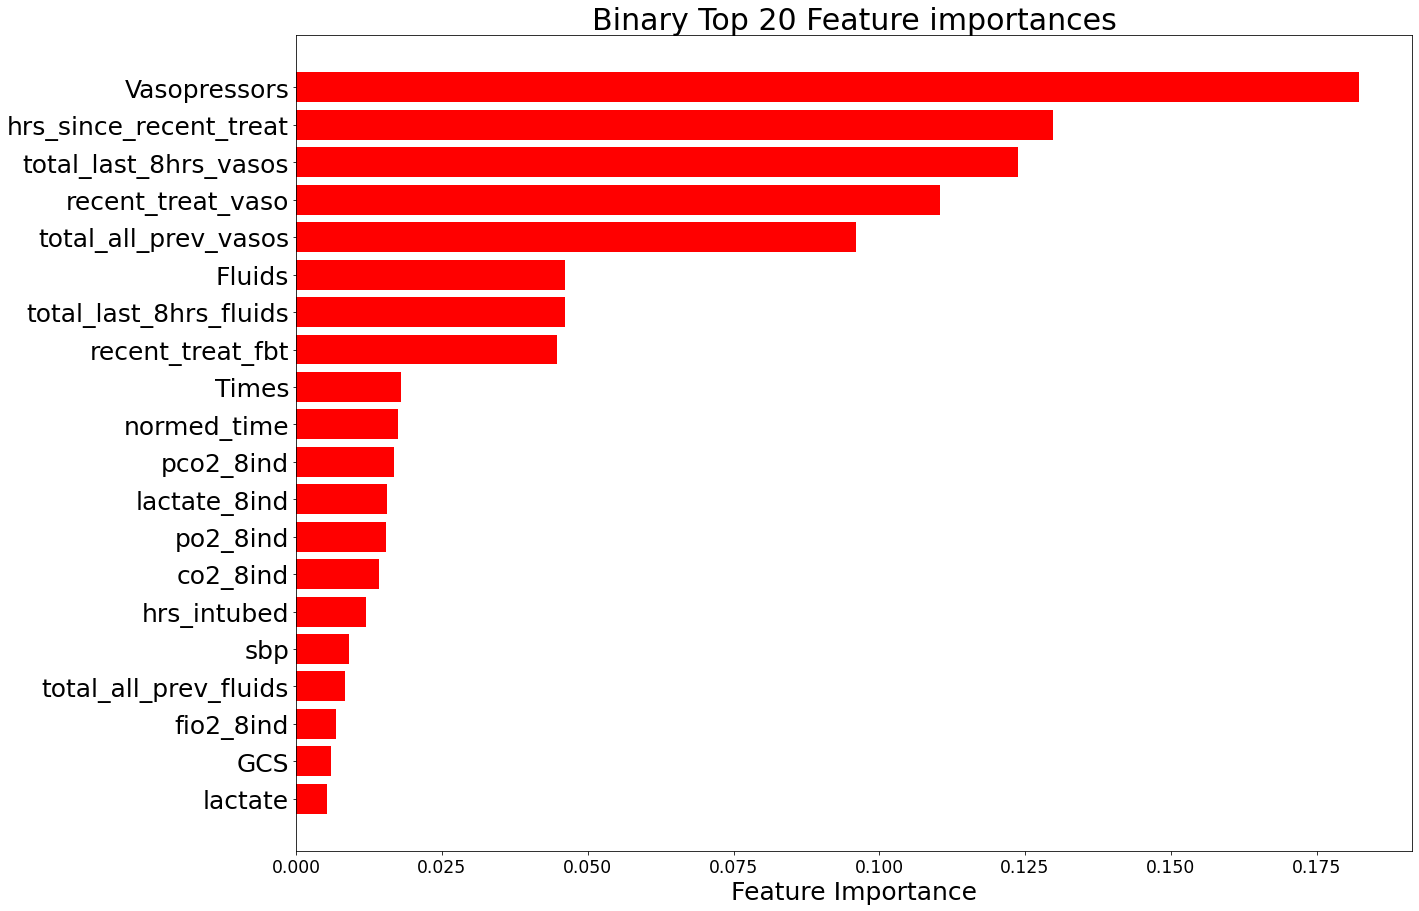

<IPython.core.display.Javascript object>

In [54]:
top_n_features(multi_clf, n=20)

In [66]:
# Create feature importance plot with readable names

feature_names = [
    "Vasopressor Dosage in Last Hour (mcg/kg/min)",
    "Hours Since Most Recent Treatment",
    "Vasopressor Dosage in Past 8 Hours",
    "Most Recent Vasopressor Treatment Dosage",
    "Total Vasopressor Dosage in the Past",
    "Fluids Dosage in Past Hour (mL)",
    "Fluids Dosage in Past 8 Hours",
    "Most Recent Fluid Treatment Dosage",
    "Hours into Admission",
    "Normalized Hours into Admission",
    "If PCO2 Was Measured in Past 8 Hours",
    "If Lactate Was Measured in Past 8 Hours",
    "If PO2 Was Measured in Past 8 Hours",
    "If CO2 Was Measured in Past 8 Hours",
    "Hours since Intubation",
    "Systolic Blood Pressure (mmHg)",
    "Total Previous Fluids Dosage (mL)",
    "If FIO2 Was Measured in Past 8 Hours",
    "Glasgow Coma Score",
    "Lactate (mg/dL)",
]

feature_importance = [
    0.18228647944446902,
    0.12980751214280145,
    0.12380436380828025,
    0.11048501529336262,
    0.09593265558814737,
    0.04617020950237626,
    0.04606931527243649,
    0.04467671917903118,
    0.017937260710900214,
    0.017461039759572635,
    0.01669381182014412,
    0.0155841785590937,
    0.015452567578618652,
    0.014222850781250502,
    0.012011311136666484,
    0.009129010361446819,
    0.00838005666014081,
    0.0068894544226273564,
    0.006048880878133099,
    0.005306698999940953,
]

len(feature_names), len(feature_importance)

(20, 20)

<IPython.core.display.Javascript object>

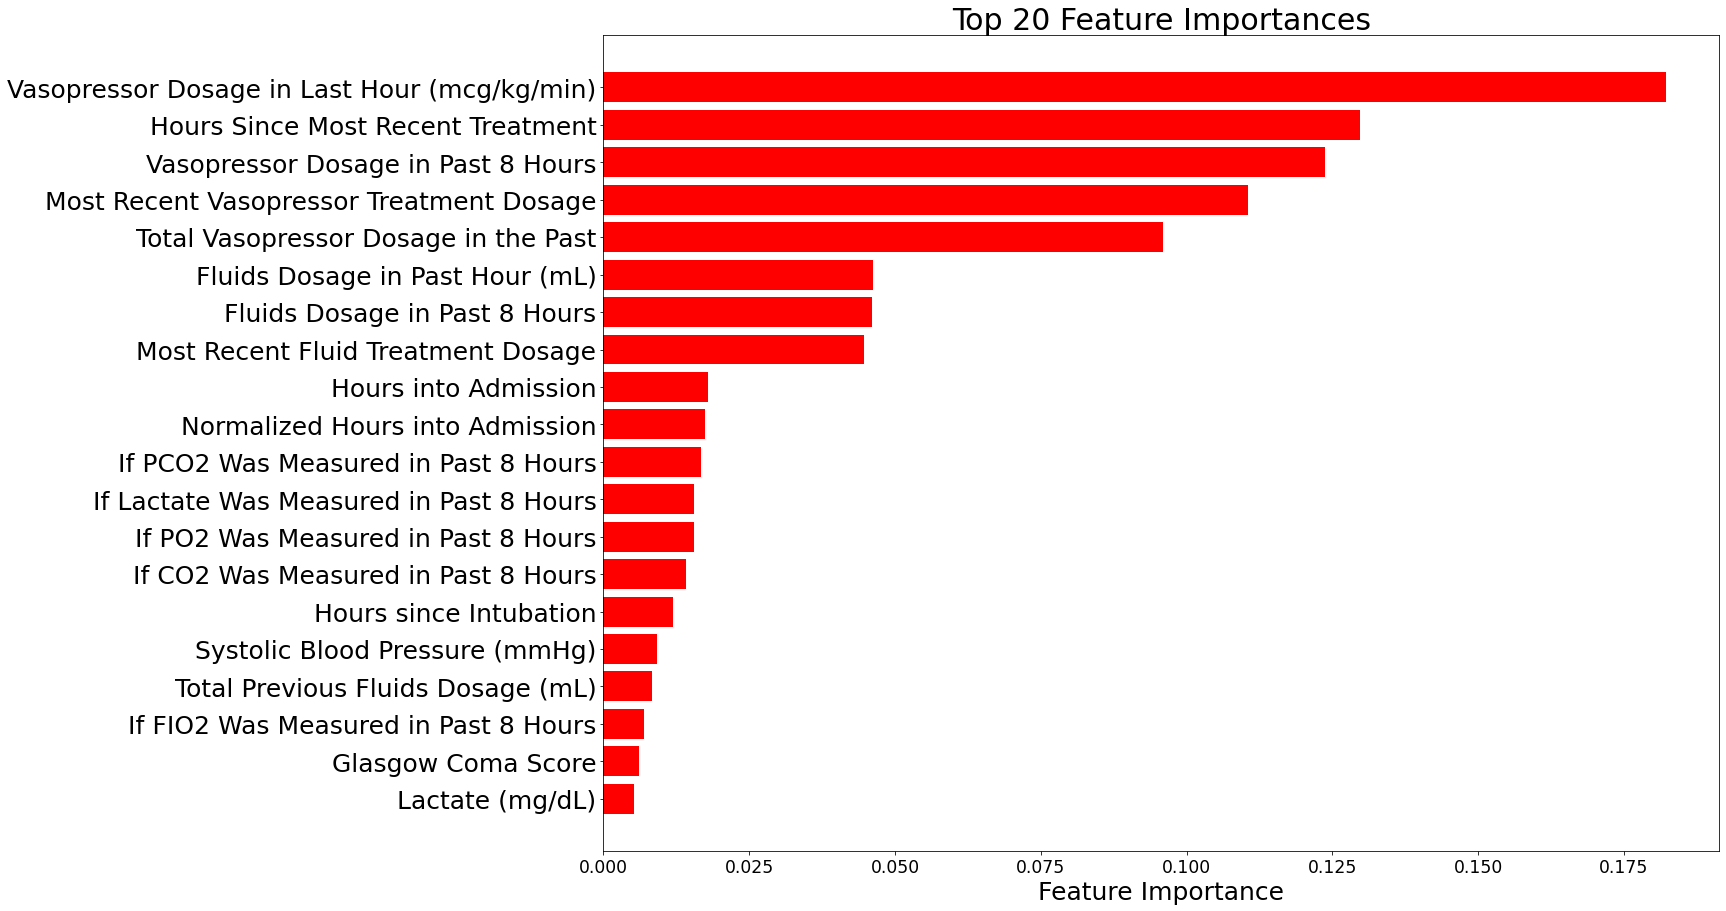

<IPython.core.display.Javascript object>

In [67]:
n = 20
plt.figure(figsize=(20, 15))
plt.title("Top 20 Feature Importances", fontsize=30)
plt.barh(range(n), feature_importance[::-1], color="r", align="center")
plt.yticks(range(n), feature_names[::-1], rotation="horizontal", fontsize=25)
plt.xlabel("Feature Importance", fontsize=25)
plt.savefig(
    "../results/visualization/Top 20 important features for 4-class Classification",
    bbox_inches="tight",
)
plt.show()

In [19]:
def remove_correlation(X_train, indices, threshold=0.9):
    d = X_train[:, indices]
    # Compute the correlation matrix
    corr = np.corrcoef(d.T)
    to_be_removed = []
    for i in range(len(indices)):
        for j in range(i):
            if (abs(corr[i, j]) >= threshold) and (j not in to_be_removed):
                to_be_removed.append(j)

    return np.delete(indices, to_be_removed)

<IPython.core.display.Javascript object>

In [20]:
multi_feat_indices_no_corr = remove_correlation(X_train_below65, multi_feat_indices)

<IPython.core.display.Javascript object>

In [21]:
# Add additional features
doctor_needed_indices = np.array(
    [
        0,
        9,
        15,
        25,
        39,
        55,
        108,
        109,
        110,
        111,
        112,
        113,
        114,
        115,
        116,
        117,
        118,
        119,
        120,
    ]
)
final_multi_feat_indices = np.union1d(multi_feat_indices_no_corr, doctor_needed_indices)

<IPython.core.display.Javascript object>

In [22]:
print(columns[final_multi_feat_indices])

Index(['Times', 'normed_time', 'bicarbonate', 'fio2', 'lactate', 'magnesium',
       'urine', 'co2', 'map', 'sbp', 'GCS', 'fio2_8ind', 'lactate_8ind',
       'magnesium_everind', 'platelets_8ind', 'hgb_8ind', 'po2_8ind',
       'po2_everind', 'hrs_intubed', 'recent_treat_fbt', 'recent_treat_vaso',
       'recent_treat_response', 'hrs_since_recent_treat', 'co2_above_30ind',
       'co2_below_20ind', 'map_above_65ind', 'fio2_above_21ind', 'Fluids',
       'Vasopressors', 'total_all_prev_vasos', 'total_all_prev_fluids',
       'total_last_8hrs_vasos', 'total_last_8hrs_fluids'],
      dtype='object')


<IPython.core.display.Javascript object>

In [23]:
multi_X_train_below65, multi_X_test_below65 = (
    X_train_below65[:, multi_feat_indices],
    X_test_below65[:, multi_feat_indices],
)
multi_clf = RandomForestClassifier(
    n_estimators=500, max_depth=5, class_weight="balanced", random_state=0
).fit(multi_X_train_below65, y_train_below65)
evaluate_clf(
    multi_X_train_below65,
    multi_X_test_below65,
    y_train_below65,
    y_test_below65,
    multi_clf,
)

Training AUC is 0.8641666743610564
Testing AUC is 0.865364301709439
Training Accuracy is 0.7585955427637976
Testing Accuracy is 0.7597614981620308


<IPython.core.display.Javascript object>

## Correlation Checking

In [46]:
def plot_correlation(indices, X_train):

    sns.set(style="white")

    d = X_train[:, indices]
    # Compute the correlation matrix
    corr = np.corrcoef(d.T)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        mask=mask,
        cmap=plt.cm.PiYG,
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )

<IPython.core.display.Javascript object>

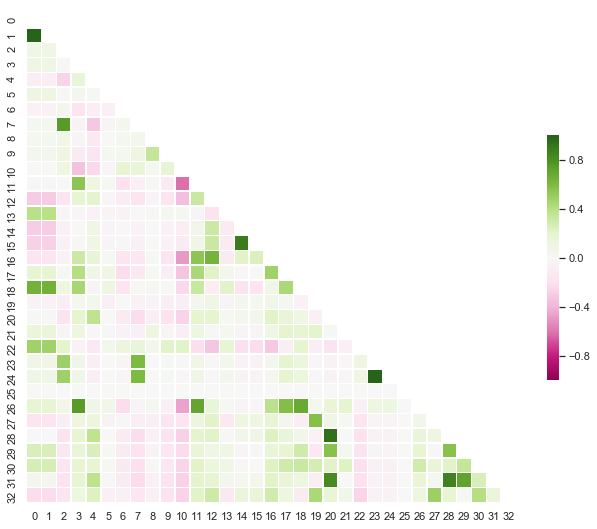

<IPython.core.display.Javascript object>

In [47]:
plot_correlation(final_multi_feat_indices, X_train_below65)

## Save Data

In [174]:
result_save_dir = "../results/intermediate/"

pickle.dump(
    final_multi_feat_indices, open(f"{result_save_dir}/selected_feature_indices.p", "wb")
)
pickle.dump(
    train_map_below65_indices, open(f"{result_save_dir}/map_below65_train_indices.p", "wb")
)
pickle.dump(
    test_map_below65_indices, open(f"{result_save_dir}/map_below65_test_indices.p", "wb")
)

<IPython.core.display.Javascript object>

In [48]:
S1_train = np.copy(X_train[:, final_multi_feat_indices])
S1_test = np.copy(X_test[:, final_multi_feat_indices])
S2_train = np.copy(X_next_train[:, final_multi_feat_indices])
S2_test = np.copy(X_next_test[:, final_multi_feat_indices])
A_train = np.copy(y_train.astype(int))
A_test = np.copy(y_test.astype(int))

<IPython.core.display.Javascript object>

In [59]:
np.save(f"{result_save_dir}/S1_train", S1_train)
np.save(f"{result_save_dir}/S1_test", S1_test)
np.save(f"{result_save_dir}/S2_train", S2_train)
np.save(f"{result_save_dir}/S2_test", S2_test)
np.save(f"{result_save_dir}/A_train", A_train)
np.save(f"{result_save_dir}/A_test", A_test)
np.save(f"{result_save_dir}/R_train", R_train)
np.save(f"{result_save_dir}/R_test", R_test)
np.save(f"{result_save_dir}/PID_train", train_pid)
np.save(f"{result_save_dir}/PID_test", test_pid)
np.save(f"{result_save_dir}/HR_train", train_hr)
np.save(f"{result_save_dir}/HR_test", test_hr)

<IPython.core.display.Javascript object>

## Learn Kernel

In [141]:
feat_idx = pickle.load(open(f'{result_save_dir}/selected_feature_indices.p', 'rb'))

Multiclass version

In [166]:
multi_y_train_below65 = y_train_below65.astype(int)
multi_y_test_below65 = y_test_below65.astype(int)
multi_class_weight = get_class_weight(multi_y_train_below65)

multi_X_train_below65 = X_train_below65[:, feat_idx]
multi_X_test_below65 = X_test_below65[:, feat_idx]

<IPython.core.display.Javascript object>

In [167]:
def run_kernel_training(
    name,
    X_train,
    X_test,
    y_train,
    y_test,
    num_cls,
    cls_weight,
    interpret=True,
    lr=0.01,
    num_epochs=150,
    report_frequency=20,
):
    """Train Kernel. Record the train/test accuracy/auc score"""

    print(name, X_train.shape[1])
    kernel_model = train_kernel(
        X_train,
        y_train,
        num_cls,
        cls_weight,
        interpret=interpret,
        lr=lr,
        num_epochs=num_epochs,
    )
    torch.save(kernel_model.state_dict(), "../results/model/" + name)

    # diagnostics
    train_proba = kernel_model(torch.from_numpy(X_train).float())
    train_pred = np.argmax(train_proba.detach().numpy(), axis=1)
    test_proba = kernel_model(torch.from_numpy(X_test).float())
    test_pred = np.argmax(test_proba.detach().numpy(), axis=1)
    print(train_pred.shape)
    print(
        "Training AUC is {0}".format(
            multiclass_roc_auc_score(y_train, train_pred, "weighted")
        )
    )
    print(
        "Testing AUC is {0}".format(
            multiclass_roc_auc_score(y_test, test_pred, "weighted")
        )
    )
    print("Training accuracy is {0}".format(accuracy_score(y_train, train_pred)))
    print("Testing accuracy is {0}".format(accuracy_score(y_test, test_pred)))

    return kernel_model

<IPython.core.display.Javascript object>

In [168]:
multi_kernel_setseed = run_kernel_training(
    "multi_withindics_interpret_kernel_setseed888",
    multi_X_train_below65,
    multi_X_test_below65,
    multi_y_train_below65,
    multi_y_test_below65,
    4,
    multi_class_weight,
    interpret=True,
)

multi_withindics_interpret_kernel_setseed888 33
Epoch 0/150, Learning Kernel Loss: 1.2026982432058604
Epoch 20/150, Learning Kernel Loss: 1.0432267035470664
Epoch 40/150, Learning Kernel Loss: 1.0374943320990053
Epoch 60/150, Learning Kernel Loss: 1.029965705840426
Epoch 80/150, Learning Kernel Loss: 1.0281777741676097
Epoch 100/150, Learning Kernel Loss: 1.026385981805145
Epoch 120/150, Learning Kernel Loss: 1.0245293914047768
Epoch 140/150, Learning Kernel Loss: 1.020413447850672
(102844,)
Training AUC is 0.8339434235312327
Testing AUC is 0.8316002281498759
Training accuracy is 0.7014993582513321
Testing accuracy is 0.6995282063156676


<IPython.core.display.Javascript object>

In [182]:
feats = columns[feat_idx]
feat_w = {
    f: np.exp(w.item()) for f, w in zip(feats, multi_kernel_setseed.log_kernel_weight)
}
feat_w = list(feat_w.items())
feat_w.sort(key=lambda x: x[1])
feat_w

[('bicarbonate', 7.314601915421128e-10),
 ('recent_treat_response', 2.8797409616287496e-09),
 ('urine', 6.750781258279692e-06),
 ('total_all_prev_vasos', 0.009849565371190232),
 ('total_all_prev_fluids', 0.018089087854130895),
 ('po2_everind', 0.02621152643871848),
 ('magnesium', 0.03257184970891793),
 ('GCS', 0.0495761089894127),
 ('fio2', 0.049687766792092566),
 ('normed_time', 0.05457857041845627),
 ('co2', 0.061193661671133215),
 ('Fluids', 0.06239658171542061),
 ('lactate_8ind', 0.07814405864065523),
 ('total_last_8hrs_fluids', 0.0895468406765786),
 ('fio2_8ind', 0.09482549761126537),
 ('recent_treat_fbt', 0.09693445919887635),
 ('lactate', 0.09917763413538595),
 ('Times', 0.10096362494760792),
 ('po2_8ind', 0.1047442668153673),
 ('sbp', 0.13509485390299883),
 ('map', 0.18231595352799135),
 ('hrs_intubed', 0.2489130344198143),
 ('Vasopressors', 0.560046903426551),
 ('map_above_65ind', 0.8719582511097762),
 ('recent_treat_vaso', 0.9167455894863185),
 ('hrs_since_recent_treat', 1.12

<IPython.core.display.Javascript object>